In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import array
from numpy import newaxis
import math
from scipy import stats
from subprocess import check_output
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
#load your data to train or predict on 
raw_data = pd.read_csv(f"https://s3.amazonaws.com/globefutures/data/CME_CL1.csv", usecols=[7])


In [4]:
df = raw_data

In [5]:
data_frame = df.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame = data_frame.sort_index(ascending=True, axis=0)
df = data_frame.reindex(index=data_frame.index[::-1])
df.tail()

,Settle
4,65.21
3,63.30
2,63.50
1,63.91
0,63.60


In [6]:
df_z = np.abs(stats.zscore(df))
print(df_z)

[[0.47236259]
 [0.4762087 ]
 [0.470964  ]
 ...
 [0.7199309 ]
 [0.7342664 ]
 [0.72342736]]


In [7]:
threshhold = 5
print(np.where(df_z>threshhold))
df_o = df[(df_z < threshhold).all(axis=1)]

(array([], dtype=int64), array([], dtype=int64))


In [8]:
print(f"Raw Data: {df.shape}")
print(f"Data with Z-Scores > {threshhold} removed: {df_o.shape}")


Raw Data: (9068, 1)
Data with Z-Scores > 5 removed: (9068, 1)


In [9]:
dataset = df_o
dataset = dataset.values
dataset = dataset.astype('float32')


In [10]:
#scale the data, makes the model happy
np.random.seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6075 2993


In [12]:
look_back = 1 # sets how many steps out from the current step model is looking, 3 is two days in our timeseries. The current day and two days out.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [14]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=batch_size, verbose=2)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 6s - loss: 0.0015
Epoch 2/100
 - 5s - loss: 4.4587e-05
Epoch 3/100
 - 5s - loss: 4.3684e-05
Epoch 4/100
 - 5s - loss: 4.2786e-05
Epoch 5/100
 - 5s - loss: 4.2676e-05
Epoch 6/100
 - 5s - loss: 4.1204e-05
Epoch 7/100
 - 5s - loss: 4.2605e-05
Epoch 8/100
 - 6s - loss: 4.1576e-05
Epoch 9/100
 - 6s - loss: 4.1269e-05
Epoch 10/100
 - 6s - loss: 4.1732e-05
Epoch 11/100
 - 6s - loss: 4.1387e-05
Epoch 12/100
 - 6s - loss: 4.1500e-05
Epoch 13/100
 - 8s - loss: 4.0665e-05
Epoch 14/100
 - 8s - loss: 4.1164e-05
Epoch 15/100
 - 8s - loss: 4.1003e-05
Epoch 16/100
 - 8s - loss: 4.0388e-05
Epoch 17/100
 - 7s - loss: 4.0778e-05
Epoch 18/100
 - 7s - loss: 3.8795e-05
Epoch 19/100
 - 7s - loss: 4.0143e-05
Epoch 20/100
 - 7s - loss: 3.9282e-05
Epoch 21/100
 - 8s - loss: 3.8705e-05
Epoch 22/100
 - 8s - loss: 3.9265e-05
Epoch 23/100
 - 7s - loss: 3.9221e-05
Epoch 24/100
 - 7s 

In [298]:
model.save('filename.h5') #change file name! lstm_modelCLstep15, lstm_modelCL

In [448]:
model = load_model('lstm_modelCL.h5') #load a model 

In [449]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size, verbose=2)
testPredict = model.predict(testX, batch_size=batch_size, verbose=2)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

ValueError: Error when checking input: expected lstm_6_input to have shape (1, 3) but got array with shape (3, 1)

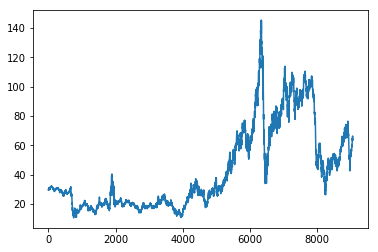

In [348]:
plt.plot(scaler.inverse_transform(dataset))


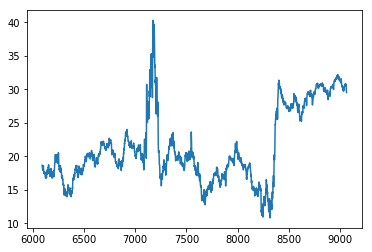

In [319]:
plt.plot(testPredictPlot)


In [438]:
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


Crude Oil Contract - Univariate

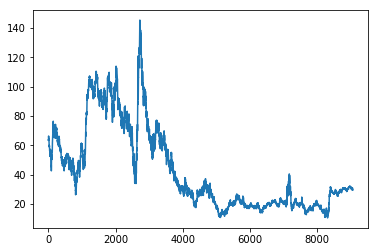